In [1]:
import cv2
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.cm
from matplotlib.cm import ScalarMappable
from cams.base_utils.LRP_util import *
from cams.calibration_util import *
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus,AblationCAM,LayerCAM

from torchvision.models import vgg,resnet

import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image, ImageDraw

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                             std = [ 1., 1., 1. ]),
                       ])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Parameters

#test_model = 'vgg16_bn'
test_model = 'resnet50'

if test_model == 'vgg16_bn':
    model = vgg.vgg16_bn(pretrained = True).to(device)
    target_layer = [model.features[-1]]
elif test_model == 'resnet50':
    model = resnet.resnet50(pretrained = True).to(device)
    target_layer = [model.layer4[-1]]
else:
    print("Wrong Model")
    assert False,'Error'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


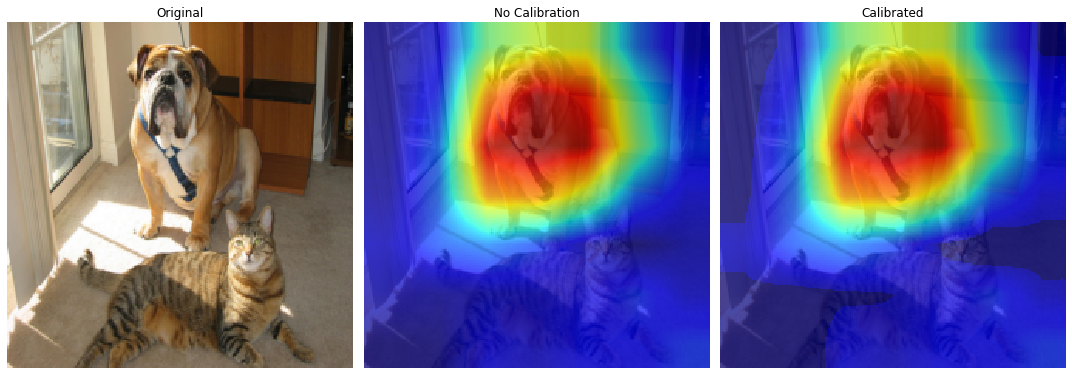

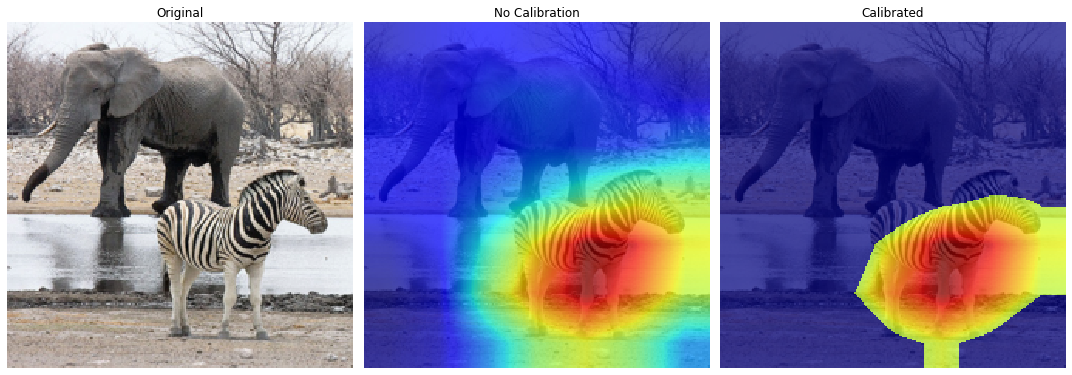

In [3]:
input_path = './Samples/'
output_path = './Results/'
if not os.path.isdir(output_path):
    os.makedirs(output_path)

files = os.listdir(input_path)
    
model.eval()

for imgname in files:
    if imgname.endswith('jpg'):
        input_img = input_path + imgname
        
    img = Image.open(input_img).convert("RGB")
    
    img_tensor = img.copy()

    in_tensor = transform(img_tensor)
    in_tensor = in_tensor.unsqueeze(axis=0)

    output = F.softmax(model(in_tensor.cuda()))
    label = output.argmax()
    maxindex = label.item()

    target_confi = output.T[label].detach().cpu().numpy().squeeze()
    
    g_cam = GradCAM(model=model,target_layers=target_layer, use_cuda = device)
    #g_pp_cam = GradCAMPlusPlus(model=model,target_layers=target_layer, use_cuda = device)
    #Ab_cam = AblationCAM(model=model,target_layers=target_layer, use_cuda = device)
    #L_cam = LayerCAM(model=model,target_layers=target_layer, use_cuda = device)

    grad_cam = g_cam(input_tensor=in_tensor)[0]
#    grad_cam_pp = g_pp_cam(input_tensor=in_tensor)[0]
#    abla_cam = Ab_cam(input_tensor=in_tensor)[0]
#    layer_cam = L_cam(input_tensor=in_tensor)[0]


    confi = F.softmax(output).max()

    best_grad_cam = get_best_cam(grad_cam,model,confi,maxindex,in_tensor)
#    best_grad_cam_pp = get_best_cam(grad_cam_pp,model,confi,maxindex,in_tensor)
#    best_abla_cam = get_best_cam(abla_cam,model,confi,maxindex,in_tensor)
#    best_layer_cam = get_best_cam(layer_cam,model,confi,maxindex,in_tensor)
    
    img_tensor2 = img.copy()

    target_img = invTrans(in_tensor.squeeze()).numpy().transpose(1,2,0)
    
    save_path = output_path + imgname[:-4]
    
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(bottom=0.01)

    plt.subplot(2, 3, 1)
    plt.imshow(target_img)
    plt.axis("off")
    plt.title('Original')
    
    plt.subplot(2, 3, 2)
    plt.imshow((grad_cam),cmap='jet')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('No Calibration')
    
    plt.subplot(2, 3, 3)
    plt.imshow((best_grad_cam),cmap='jet')
    plt.imshow(target_img,alpha = 0.3)
    plt.axis("off")
    plt.title('Calibrated')
    
    plt.tight_layout()
    
    plt.show()